In [1]:
CrossValCalcIt = false       #true: do cross validation calculations

false

In [2]:
import Formatting
using PyPlot

include("jlFiles/printmat.jl")
include("jlFiles/excise.jl")
include("jlFiles/lagnPs.jl")
include("jlFiles/KernRegNormalFn.jl")
include("jlFiles/KernRegUniformFn.jl")
include("jlFiles/OlsFn.jl")

OlsFn (generic function with 1 method)

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',header=true)
R   = xx[1]
ymd = R[:,1]             #[YearMonthDay]
R   = R[:,11]            #returns for the size portfolio we want to study

xx  = excise([R lagnPs(R)])             #return and lagged return: dependent variable and regressor
y   = xx[:,1]
x   = xx[:,2]
T   = size(x,1)

8324

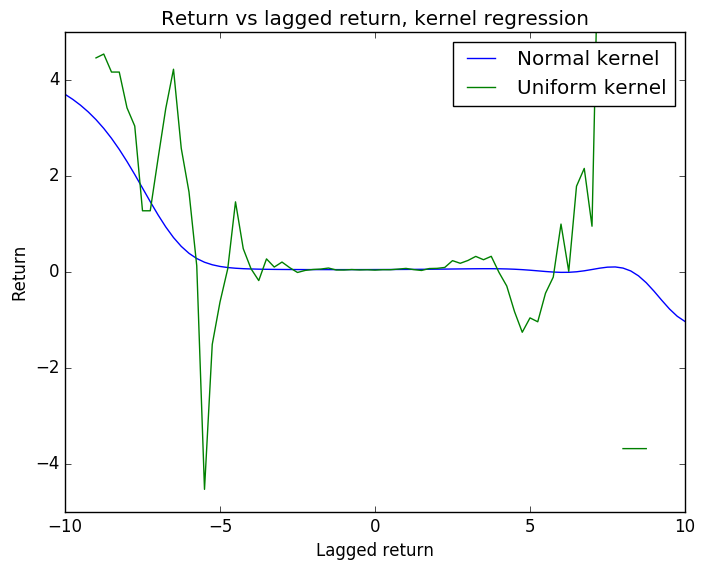

In [4]:
xGrid = collect(-10:0.25:10)
h     = 1.5
bHat  = KernRegNormalFn(y,x,xGrid,h,1:T)

xGridU = collect(-9.5:0.25:9.5)
bHatU  = KernRegUniformFn(y,x,xGridU,1)

figure()
  ha = plot(xGrid,bHat,xGridU,bHatU)
  xlim(minimum(xGrid),maximum(xGrid))
  ylim(-5,5)
  title("Return vs lagged return, kernel regression")
  xlabel("Lagged return")
  ylabel("Return")
  legend(["Normal kernel";"Uniform kernel"])
show()

In [5]:
(b,res,) = OlsFn(y,[x.^2 x ones(T,1)])             #rule of thumb bandwidth

sigma = std(res)
gamm  = b[1]
xSort = sort(x)
x_10  = xSort[round(Int,floor(T*0.1))]          #crude 10th and 90th percentiles
x_90  = xSort[round(Int,floor(T*0.9))]

h_crude0 = 0.6*sigma^(2/5)*abs(gamm)^(-2/5)*(x_90-x_10)^(1/5)*T^(-1/5)
h_crude  = 0.67

println("\nInitial choice of h: two versions")
printmat([h_crude0 h_crude])


Initial choice of h: two versions
     0.667     0.670



In [6]:
if CrossValCalcIt

  println("\nCross-validation calculations take some time")

  hM = h_crude*[0.25 0.5 0.75 1 1.5 2 3 4 5 10]'

  Nh   = length(hM)
  EPEM = fill(NaN,(T,Nh))
  for t = 1:T
    v_No_t = setdiff(1:T,t)
    for j = 1:Nh
      b_t       = KernRegNormalFn(y,x,x[t],hM[j],v_No_t)   #fitted b[x(t)]
      EPEM[t,j] = (y[t] - b_t[1])^2
    end
  end
  EPE = mean(EPEM,1)'
  println("h and EPE:")
  printmat([hM EPE])

  figure()
    ha = plot(hM,EPE/minimum(EPE))
    xlim(minimum(hM)-0.05,maximum(hM)+0.05)
    ylim(0.99,1.025)
    title("Cross validation simulations, kernel regression")
    xlabel("Bandwidth")
    ylabel("EPE")
    show()

end